In [1]:
from modules.recognition.model import OCRModel
from modules.recognition.dataset import OCRVietnamese, ClusterRandomSampler
from modules.recognition.train import train_model
from modules.recognition.utils import process_image
from modules.recognition.vocab import Vocabulary
from modules.recognition.loss import LabelSmoothingLoss

from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch
import os

from configs.recognition_config import d_model, d_ff, num_heads, num_decoder_layers, dropout, maxlen, device

vocab = Vocabulary(maxlen=maxlen)
vocab_size = len(vocab)
vocab_size

232

In [2]:
root = './datasets/img/'
train = []
with open(root + 'annotation_train.txt', 'r') as f:
    annotations = [l.strip().split("\t") for l in f.readlines()] 
    for image_path, text in annotations:
        train.append({
            'image_path': root+image_path,
            'text': text
        })
        
val = []
with open(root + 'annotation_val_small.txt', 'r') as f:
    valid = [l.strip().split("\t") for l in f.readlines()] 
    for image_path, text in annotations:
        val.append({
            'image_path': root+image_path,
            'text': text
        })

len(train), len(val)

(5483, 5483)

In [3]:
batch_size = 32

# test_len = int(len(annotations)*0.01) #% test
# train, test = torch.utils.data.random_split(annotations, [len(annotations)-test_len, test_len])

train_dataset = OCRVietnamese(train, vocab, process_image, maxlen)
train_sampler = ClusterRandomSampler(train_dataset, batch_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

val_dataset = OCRVietnamese(val, vocab, process_image, maxlen)
val_sampler = ClusterRandomSampler(val_dataset, batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)

  0%|          | 0/5483 [00:00<?, ?it/s]

  0%|          | 0/5483 [00:00<?, ?it/s]

In [4]:
model = OCRModel(
    vocab_size=vocab_size,
    d_model = d_model,
    num_heads = num_heads,
    d_ff = d_ff,
    num_decoder_layers = num_decoder_layers,
    dropout = dropout
)

optimizer = AdamW(model.parameters(), betas=(0.9, 0.98), eps=1e-09)
criterion = LabelSmoothingLoss(classes=vocab_size, padding_idx=vocab.char2idx['<pad>'], smoothing=0.1)

In [5]:
epochs = 20
is_train = True

In [6]:
model_name = f'model_weights-{epochs}'
if os.path.exists(f'./checkpoints/recognition/{model_name}.pth'):
    state_dict = torch.load(f'./checkpoints/recognition/{model_name}.pth')
    model.load_state_dict(state_dict)
    print('weights loaded')
    
if is_train:
    train_model(model, train_loader, optimizer, criterion, device, vocab, epochs) # đang train với test_loader
    torch.save(model.state_dict(), f'./checkpoints/recognition/{model_name}.pth')

  0%|          | 0/172 [00:00<?, ?it/s]

/Users/hung/Desktop/OCR/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: [1/20], Average Loss: 1.0306
Avg Accuracy per char: 0.0253, , Avg Accuracy full seq: 0.0117


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch: [2/20], Average Loss: 0.8088
Avg Accuracy per char: 0.1116, , Avg Accuracy full seq: 0.0833


  0%|          | 0/172 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from modules.recognition.eval import evaluate
# avg_loss, acc_per_char, acc_full_seq = evaluate(model, val_loader, criterion, device, vocab)
# 18m53s
# Evaluation - Avg Loss: 0.2314, Avg Accuracy per char: 25.0548, , Avg Accuracy full seq: 24.8388

# infer

actual:  bị mất sạch giấy tờ và phải quay về quê vất vả hoàn tất rất
generated:  bị mất sạch giấy tờ và phải quay về quê vất vả hoàn tất rất


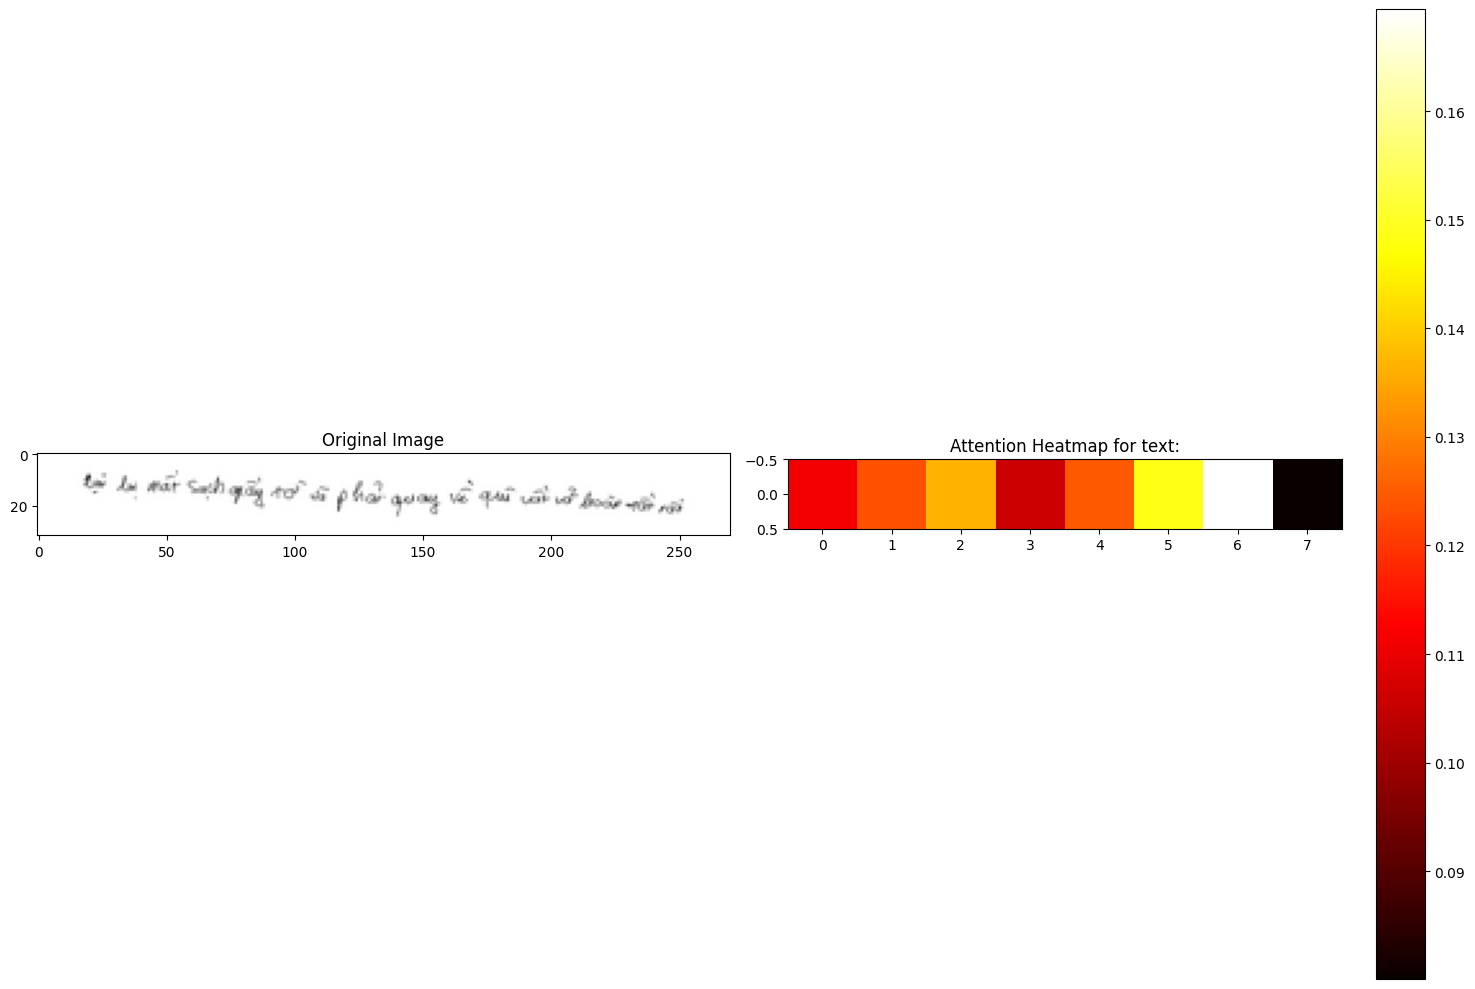

In [ ]:
img, txt, path = val_dataset.get_random_image()

pred_txt, f ,a  = model.generate_text(img.unsqueeze(0), vocab)
model.visualize_attention(img, txt, pred_txt[0], f, a)